### Importing Dataset From Kaggle

In [ ]:
!pip install imbalanced-learn

In [ ]:
#!/bin/bash
!kaggle datasets download safrin03/predictive-analytics-for-customer-churn-dataset
!unzip predictive-analytics-for-customer-churn-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/safrin03/predictive-analytics-for-customer-churn-dataset
License(s): other
 83% 20.0M/24.0M [00:00<00:00, 30.9MB/s]
100% 24.0M/24.0M [00:00<00:00, 35.0MB/s]
Archive:  predictive-analytics-for-customer-churn-dataset.zip
  inflating: data_descriptions.csv   
  inflating: test.csv                
  inflating: train.csv               


### Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix,
    balanced_accuracy_score, matthews_corrcoef
)
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Loading Datasets

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### EDA Before Preprocessing - Referenced from Shravani's EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating                243787 non-null  f

In [ ]:
train_df.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000
mean,60.083758,12.490695,750.741017,20.502179,92.264061,24.503513,3.002713,4.504186,12.018508,0.181232
std,34.285143,4.327615,523.073273,11.243753,50.505243,14.421174,1.155259,2.872548,7.193034,0.385211
min,1.000000,4.990062,4.991154,1.000065,5.000547,0.000000,1.000007,0.000000,0.000000,0.000000
25%,30.000000,8.738543,329.147027,10.763953,48.382395,12.000000,2.000853,2.000000,6.000000,0.000000
50%,60.000000,12.495555,649.878487,20.523116,92.249992,24.000000,3.002261,4.000000,12.000000,0.000000
75%,90.000000,16.238160,1089.317362,30.219396,135.908048,37.000000,4.002157,7.000000,18.000000,0.000000
max,119.000000,19.989957,2378.723844,39.999723,179.999275,49.000000,4.999989,9.000000,24.000000,1.000000


### Feature Engineering

In [ ]:
def add_engineered_features(train_df):

    # 1. TotalSpendingRatio - Represents the average spending per unit of account age.
    train_df['TotalSpendingRatio'] = train_df['TotalCharges'] / train_df['AccountAge']

    # 2. MonthlyChangeInCharges - Measures any changes in monthly charges over time, highlighting potential pricing adjustments that could affect churn.
    train_df['MonthlyChangeInCharges'] = train_df['MonthlyCharges'] - (train_df['TotalCharges'] / train_df['AccountAge'])

    # 3. ViewingIntensity - Reflects how much a customer watches compared to their watchlist size, which can show their engagement with available content.
    train_df['ViewingIntensity'] = train_df.apply(
        lambda row: row['ViewingHoursPerWeek'] / row['WatchlistSize'] if row['WatchlistSize'] != 0 else 0,
        axis=1)

    # 4. SupportEngagementRatio - Compares support requests to engagement levels, identifying customers who might be less satisfied or experiencing issues.
    train_df['SupportEngagementRatio'] = train_df.apply(
        lambda row: row['SupportTicketsPerMonth'] / row['ViewingHoursPerWeek'] if row['ViewingHoursPerWeek'] != 0 else 0,
        axis=1)

    # 5. ContentConsumptionScore - Aggregates ViewingHoursPerWeek, AverageViewingDuration, and ContentDownloadsPerMonth as a measure of content consumption intensity.
    train_df['ContentConsumptionScore'] = (train_df['ViewingHoursPerWeek'] +
                                           train_df['AverageViewingDuration'] +
                                           train_df['ContentDownloadsPerMonth'])

    # 6. CustomerTenureEngagement - Tracks engagement based on tenure, which could highlight long-term customers at risk of churning.
    train_df['CustomerTenureEngagement'] = train_df.apply(
        lambda row: row['AccountAge'] / row['ViewingHoursPerWeek'] if row['ViewingHoursPerWeek'] != 0 else 0,
        axis=1
    )

    return train_df

train_df = add_engineered_features(train_df)


In [ ]:
def encode_features(train_df):

    # 1. Ordinal Encoding for SubscriptionType
    subscription_mapping = {'Basic': 0, 'Standard': 1, 'Premium': 2}
    train_df['SubscriptionType'] = train_df['SubscriptionType'].map(subscription_mapping)

    # 2. One-Hot Encoding for All Other Categorical Features
    categorical_features = ['ParentalControl', 'SubtitlesEnabled', 'Gender',
                            'PaperlessBilling', 'MultiDeviceAccess', 'PaymentMethod',
                            'ContentType', 'DeviceRegistered', 'GenrePreference']

    train_df = pd.get_dummies(train_df, columns=categorical_features)


    return train_df

# Applying the function to train_df
train_df = encode_features(train_df)


In [ ]:
train_df = train_df.drop(['CustomerID'], axis=1)

# Separating features and target
X = train_df.drop(columns=['Churn'])
y = train_df['Churn']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Getting feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

Feature Importances:
 ContentConsumptionScore           0.078239
AccountAge                        0.066848
AverageViewingDuration            0.065548
TotalCharges                      0.062284
SupportEngagementRatio            0.061475
ViewingHoursPerWeek               0.059554
CustomerTenureEngagement          0.058663
MonthlyCharges                    0.058461
TotalSpendingRatio                0.057970
UserRating                        0.056044
ContentDownloadsPerMonth          0.055042
ViewingIntensity                  0.054633
WatchlistSize                     0.037849
SupportTicketsPerMonth            0.027727
SubscriptionType                  0.014369
ContentType_Both                  0.007583
ContentType_TV Shows              0.007500
ParentalControl_No                0.007451
ParentalControl_Yes               0.007437
PaperlessBilling_No               0.007428
MultiDeviceAccess_Yes             0.007412
PaperlessBilling_Yes              0.007379
MultiDeviceAccess_No            

In [ ]:
# Selecting only the important features based on feature importance calculated by Random Forest Classifier
selected_features = [
    "ContentConsumptionScore", "AccountAge", "AverageViewingDuration",
    "TotalCharges", "SupportEngagementRatio", "ViewingHoursPerWeek",
    "CustomerTenureEngagement", "MonthlyCharges", "TotalSpendingRatio",
    "UserRating", "ContentDownloadsPerMonth", "ViewingIntensity",
    "WatchlistSize", "SupportTicketsPerMonth", "SubscriptionType", "Churn"
]

# Retaining only the selected features
train_df = train_df[selected_features]

In [ ]:
#Skewness Corrector
#Log Transformation
features_to_correct = ['CustomerTenureEngagement', 'ViewingIntensity']
for col in features_to_correct:
    train_df[col] = np.log1p(train_df[col])

#Sqrt Transformation
train_df['TotalCharges'] = np.sqrt(train_df['TotalCharges'])
train_df['SupportEngagementRatio'] = np.sqrt(train_df['SupportEngagementRatio'])

<ipython-input-9-ec42197c730e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = np.log1p(train_df[col])
<ipython-input-9-ec42197c730e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['TotalCharges'] = np.sqrt(train_df['TotalCharges'])
<ipython-input-9-ec42197c730e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
# Outlier Handling
def winsorize_column(series, lower_percentile=0.01, upper_percentile=0.99):
    return winsorize(series, limits=(lower_percentile, 1 - upper_percentile))

# These are the features with outliers
features_with_outliers = ['SupportEngagementRatio', 'CustomerTenureEngagement', 'ViewingIntensity']
for feature in features_with_outliers:
    train_df[feature] = winsorize_column(train_df[feature])


### EDA After Preprocessing

In [ ]:
# Calculate skewness for each column
skewness = train_df.skew()
print(skewness)

ContentConsumptionScore     0.001255
AccountAge                 -0.002506
AverageViewingDuration      0.002758
TotalCharges               -0.043250
SupportEngagementRatio      1.423026
ViewingHoursPerWeek        -0.001340
CustomerTenureEngagement    0.760241
MonthlyCharges             -0.003584
TotalSpendingRatio         -0.003584
UserRating                 -0.000958
ContentDownloadsPerMonth   -0.000427
ViewingIntensity            1.036623
WatchlistSize              -0.004500
SupportTicketsPerMonth     -0.000896
SubscriptionType            0.001752
Churn                       1.655044
dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

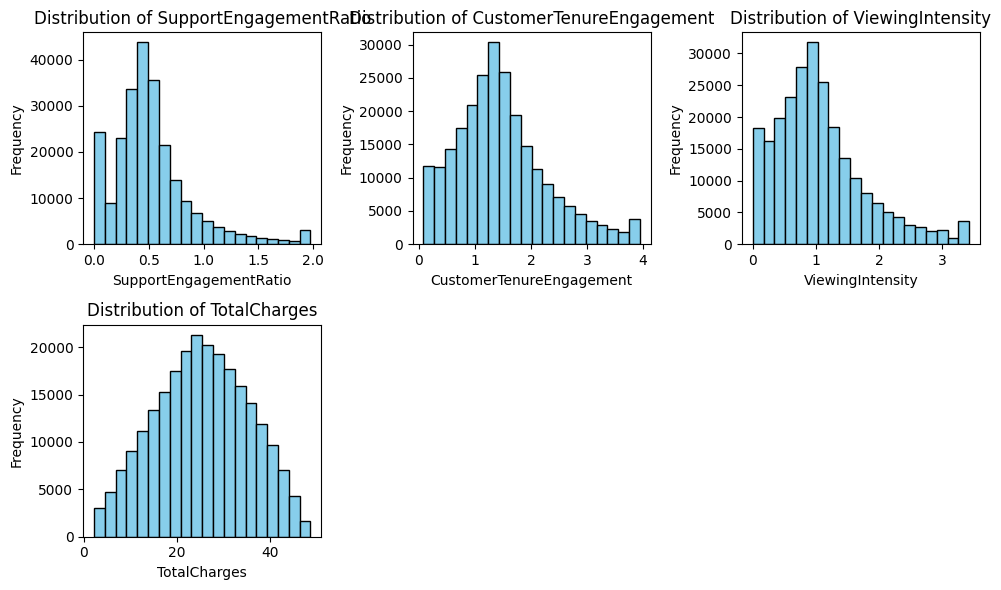

In [ ]:
#Plotting the features that were skewed
features_to_plot = ['SupportEngagementRatio', 'CustomerTenureEngagement', 'ViewingIntensity', 'TotalCharges']
plt.figure(figsize=(10, 6))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.hist(train_df[feature], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt

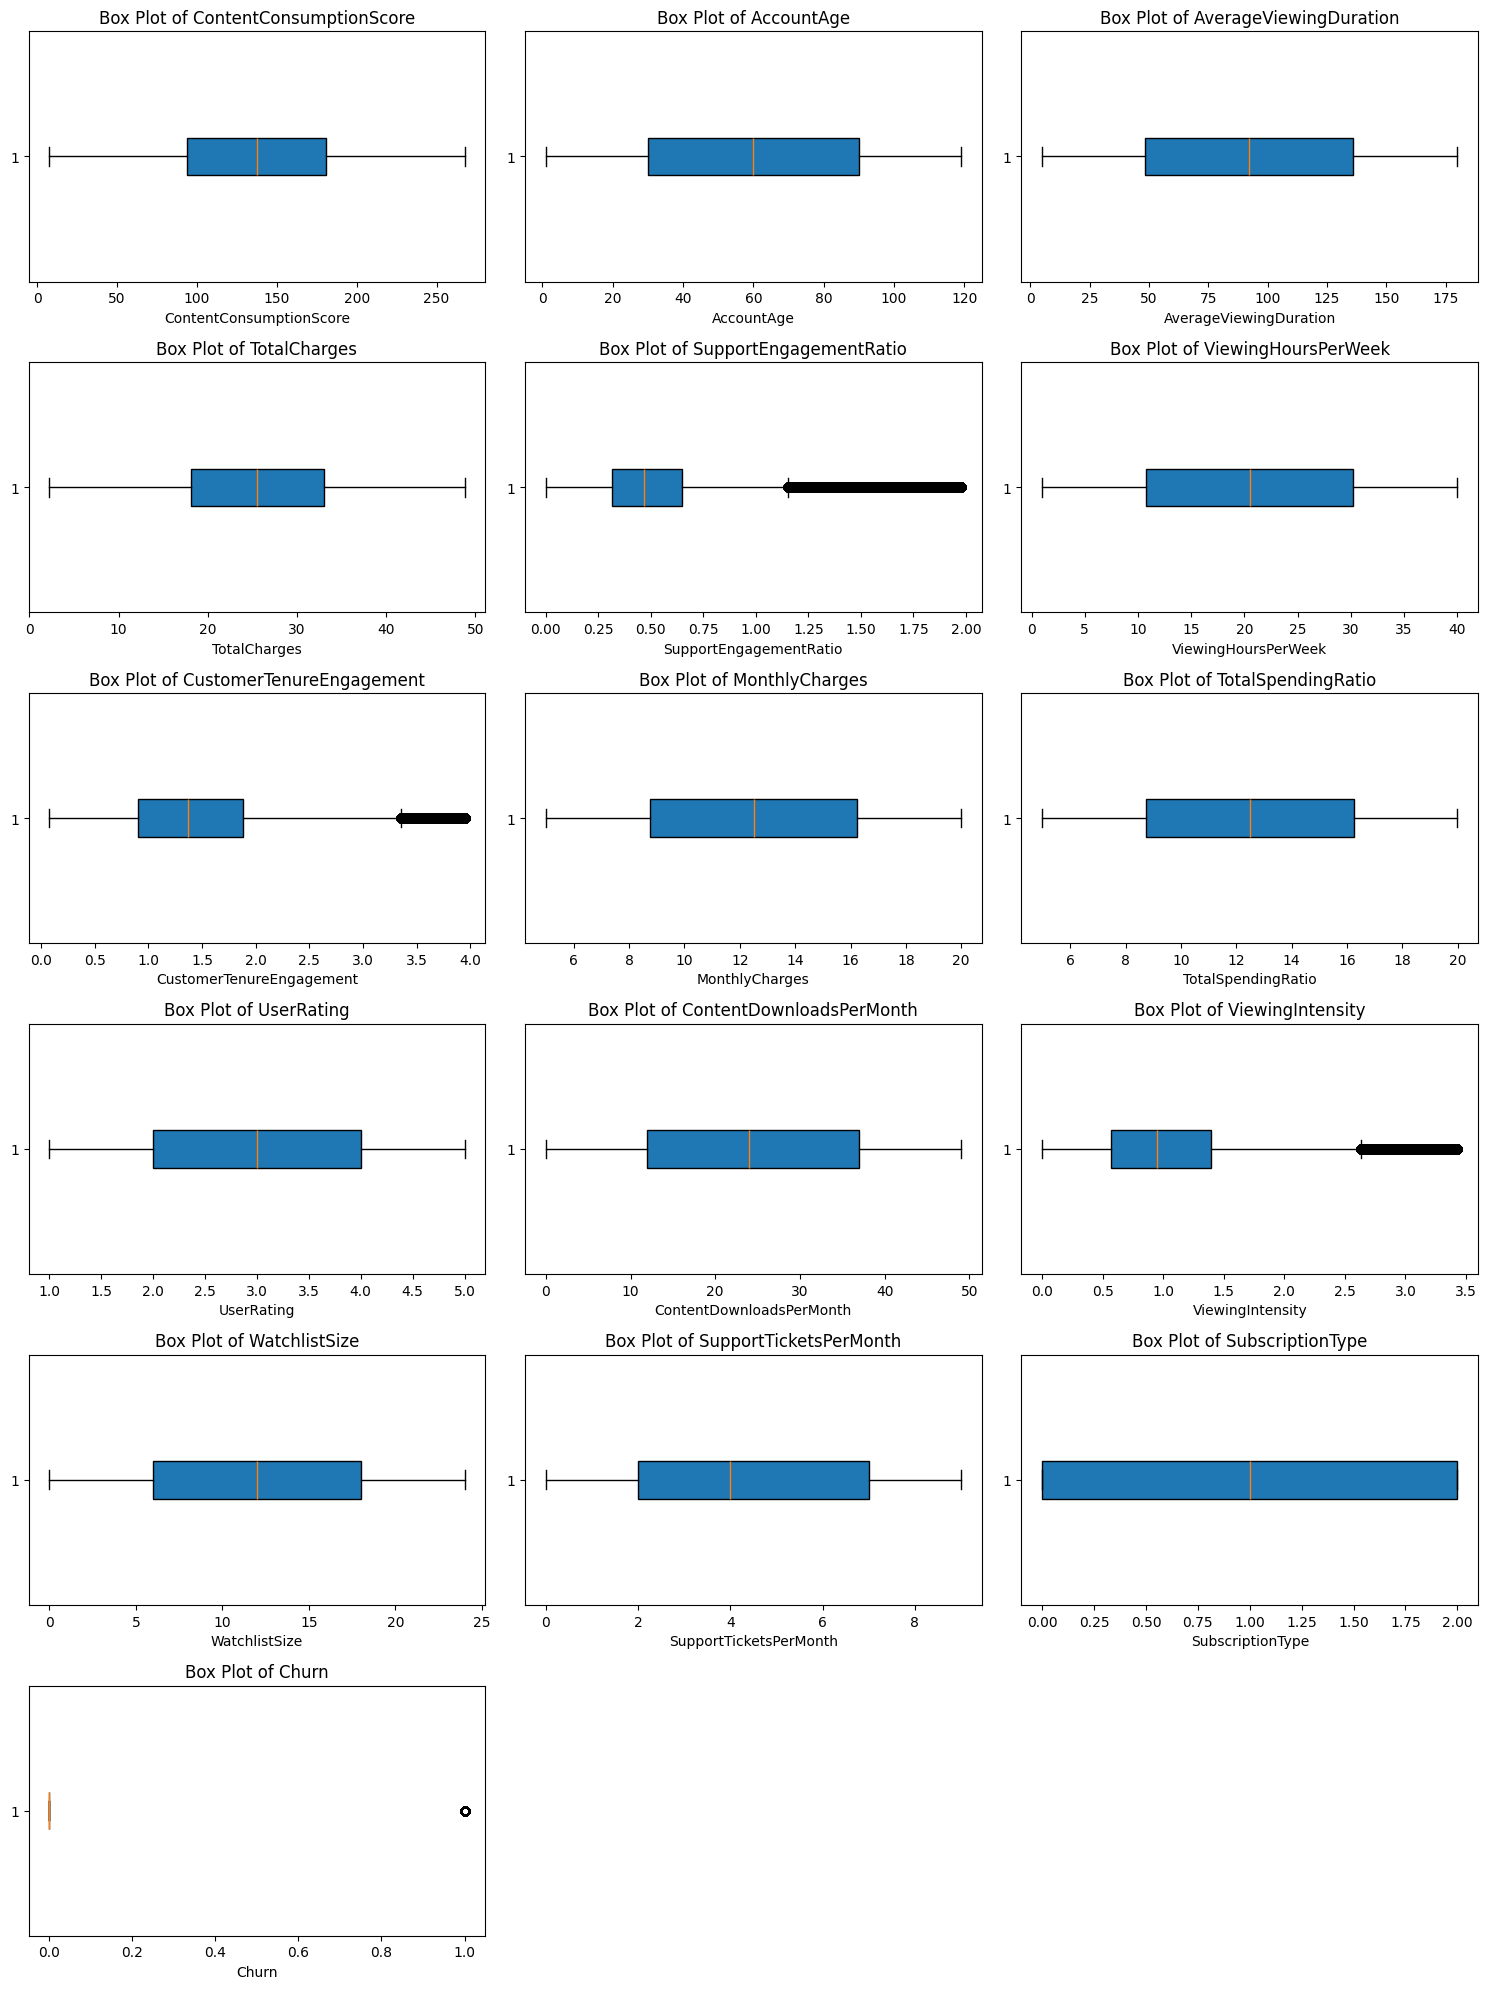

In [ ]:
# Box plot analysis for outlier detection
features = train_df.columns

plt.figure(figsize=(15, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features) // 3 + 1, 3, i)
    plt.boxplot(train_df[feature].dropna(), vert=False, patch_artist=True)
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

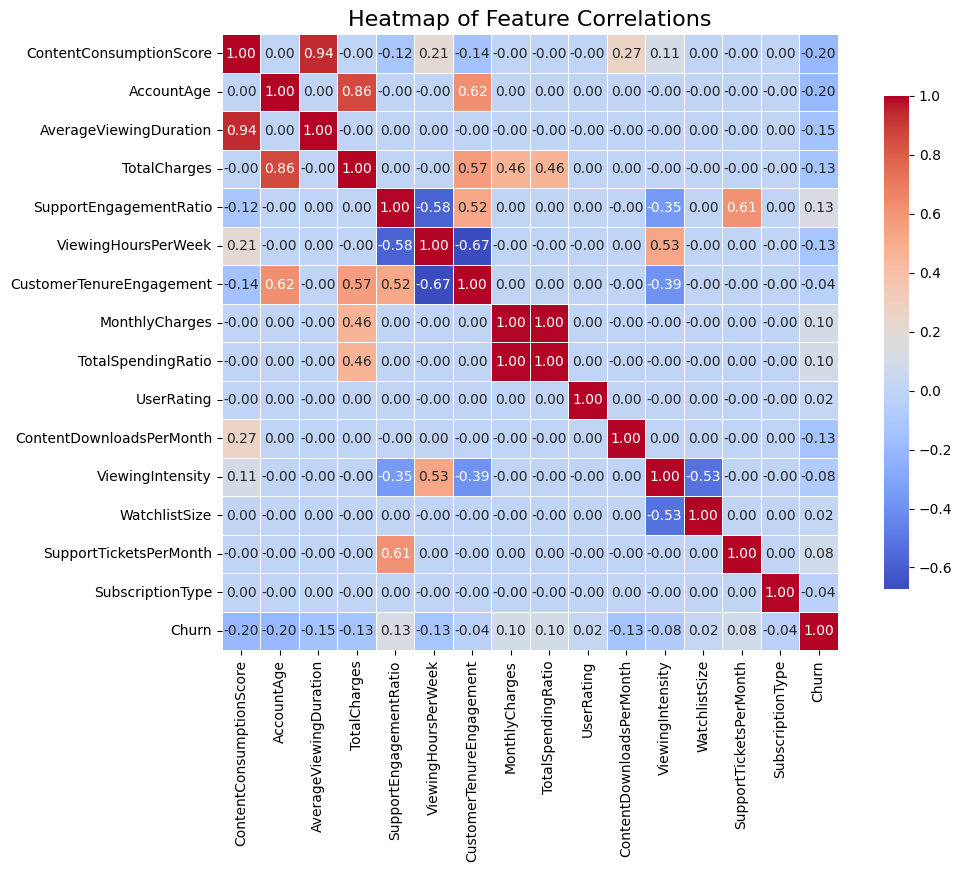

In [ ]:
# Correlation Matrix - Here negative correlation for target feature indicates that customers are not churning
correlation_matrix = train_df.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

plt.title('Heatmap of Feature Correlations', fontsize=16)
plt.show()

### Robust Normaliztion - Selected because it can handle outliers efficiently

In [ ]:
X = train_df.drop('Churn', axis=1)  # Features
y = train_df['Churn']               # Target

scaler = RobustScaler()
X_robust_normalized = scaler.fit_transform(X)

X_robust_normalized_df = pd.DataFrame(X_robust_normalized, columns=X.columns)


### Random Forest Classifier with SMOTE sampling (Overfitting)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_robust_normalized_df, y, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

resampled_data = pd.concat([X_train_resampled, pd.Series(y_train_resampled, name='Churn')], axis=1)

X_resampled = resampled_data.drop('Churn', axis=1)
y_resampled = resampled_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.25,
                                                    random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions and get predicted probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     37281
           1       0.86      0.89      0.88     37533

    accuracy                           0.87     74814
   macro avg       0.87      0.87      0.87     74814
weighted avg       0.87      0.87      0.87     74814

Random Forest Classifier With SMOTE Sampling
Accuracy: 0.8731
Precision: 0.8624
Recall: 0.8888
F1 Score: 0.8754
ROC AUC Score: 0.9475
Specificity (True Negative Rate): 0.8572
Balanced Accuracy: 0.8730
Matthews Correlation Coefficient (MCC): 0.7464


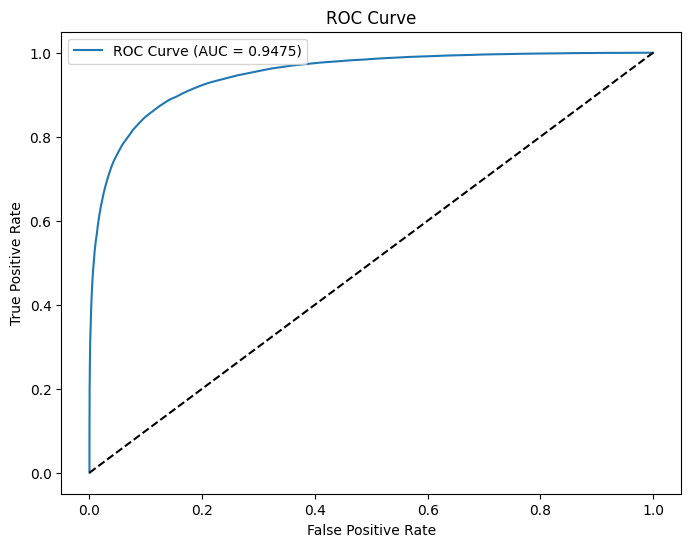

In [ ]:
# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
specificity = tn / (tn + fp)  # True Negative Rate
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Display evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Random Forest Classifier With SMOTE Sampling")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()




In [ ]:
# Train Set
y_pred_train = model.predict(X_train)
y_prob_train = model.predict_proba(X_train)[:, 1]
print("Classification Report\n", classification_report(y_train, y_pred_train))
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))


Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    112346
           1       1.00      1.00      1.00    112094

    accuracy                           1.00    224440
   macro avg       1.00      1.00      1.00    224440
weighted avg       1.00      1.00      1.00    224440

roc_auc--> 1.0


### Light GBM With SMOTE Sampling (This model does not overfit)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_robust_normalized_df, y, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

resampled_data = pd.concat([X_train_resampled, pd.Series(y_train_resampled, name='Churn')], axis=1)

X_resampled = resampled_data.drop('Churn', axis=1)
y_resampled = resampled_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.25,
                                                    random_state=42)

smote_lgbm = LGBMClassifier(random_state=42, verbosity=-1)
smote_lgbm.fit(X_train, y_train)

# Test Set
y_pred = smote_lgbm.predict(X_test)
y_prob = smote_lgbm.predict_proba(X_test)[:, 1]
print("Classification Report\n", classification_report(y_test, y_pred))
print("roc_auc-->", roc_auc_score(y_test, y_prob))



Classification Report
               precision    recall  f1-score   support

           0       0.82      0.97      0.89     37281
           1       0.96      0.79      0.87     37533

    accuracy                           0.88     74814
   macro avg       0.89      0.88      0.88     74814
weighted avg       0.89      0.88      0.88     74814

roc_auc--> 0.9397109476629102


In [ ]:
# Train Set
y_pred_train = smote_lgbm.predict(X_train)
y_prob_train = smote_lgbm.predict_proba(X_train)[:, 1]
print("Classification Report\n", classification_report(y_train, y_pred_train))
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.97      0.89    112346
           1       0.96      0.80      0.87    112094

    accuracy                           0.89    224440
   macro avg       0.90      0.89      0.88    224440
weighted avg       0.90      0.89      0.88    224440

roc_auc--> 0.9433428939653304


### Hyperparameter Tuning

In [ ]:
params = {
    "max_depth": [5, 10],               # Limit depth to smaller values
    "n_estimators": [300, 500, 700],         # Reduce number of boosting rounds
    "learning_rate": [0.1],       # Use higher learning rates
    "num_leaves": [20],             # Limit the number of leaves
    "reg_alpha": [0.1],                 # Fix regularization parameters
    "reg_lambda": [0.1]
}

# Initialize LGBMClassifier and set up GridSearchCV with reduced parameters
smote_lgbm = LGBMClassifier(random_state=42)
smote_lgbm_cv = GridSearchCV(
    estimator=smote_lgbm,
    param_grid=params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

# Fit GridSearchCV
smote_lgbm_cv.fit(X_train, y_train)

# Display best parameters and score
print("Best Params-->", smote_lgbm_cv.best_params_)
print("Best Score-->", smote_lgbm_cv.best_score_)

# Train the final model using best parameters
model_tuned = smote_lgbm.set_params(**smote_lgbm_cv.best_params_).fit(X_train, y_train)

# Evaluate on the test set
y_pred = model_tuned.predict(X_test)
y_prob = model_tuned.predict_proba(X_test)[:, 1]

# Print classification report and ROC AUC score
print("Classification Report\n", classification_report(y_test, y_pred))
print("roc_auc-->", roc_auc_score(y_test, y_prob))

Best Params--> {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best Score--> 0.8778805175683274
Classification Report
               precision    recall  f1-score   support

           0       0.83      0.97      0.90     37281
           1       0.97      0.80      0.88     37533

    accuracy                           0.89     74814
   macro avg       0.90      0.89      0.89     74814
weighted avg       0.90      0.89      0.89     74814

roc_auc--> 0.940859977198946


In [ ]:
# Train Set
y_pred_train = model_tuned.predict(X_train)
y_prob_train = model_tuned.predict_proba(X_train)[:, 1]
print("Classification Report\n", classification_report(y_train, y_pred_train))
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))

Classification Report
               precision    recall  f1-score   support

           0       0.84      0.98      0.91    112346
           1       0.98      0.81      0.89    112094

    accuracy                           0.90    224440
   macro avg       0.91      0.90      0.90    224440
weighted avg       0.91      0.90      0.90    224440

roc_auc--> 0.9564537741793598


### Building Model Pipeline

In [ ]:
train_df = pd.read_csv('train.csv')

In [ ]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['TotalSpendingRatio'] = X['TotalCharges'] / X['AccountAge']
        X['MonthlyChangeInCharges'] = X['MonthlyCharges'] - (X['TotalCharges'] / X['AccountAge'])
        X['ViewingIntensity'] = X.apply(
            lambda row: row['ViewingHoursPerWeek'] / row['WatchlistSize'] if row['WatchlistSize'] != 0 else 0,
            axis=1
        )
        X['SupportEngagementRatio'] = X.apply(
            lambda row: row['SupportTicketsPerMonth'] / row['ViewingHoursPerWeek'] if row['ViewingHoursPerWeek'] != 0 else 0,
            axis=1
        )
        X['ContentConsumptionScore'] = (X['ViewingHoursPerWeek'] +
                                        X['AverageViewingDuration'] +
                                        X['ContentDownloadsPerMonth'])
        X['CustomerTenureEngagement'] = X.apply(
            lambda row: row['AccountAge'] / row['ViewingHoursPerWeek'] if row['ViewingHoursPerWeek'] != 0 else 0,
            axis=1
        )
        return X

class CategoricalEncoding(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        subscription_mapping = {'Basic': 0, 'Standard': 1, 'Premium': 2}
        X['SubscriptionType'] = X['SubscriptionType'].map(subscription_mapping)
        return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features = selected_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.selected_features]

class SkewnessCorrection(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['CustomerTenureEngagement'] = np.log1p(X['CustomerTenureEngagement'])
        X['ViewingIntensity'] = np.log1p(X['ViewingIntensity'])
        X['TotalCharges'] = np.sqrt(X['TotalCharges'])
        X['SupportEngagementRatio'] = np.sqrt(X['SupportEngagementRatio'])
        return X

class OutlierHandling(BaseEstimator, TransformerMixin):
    def __init__(self, features_with_outliers):
        self.features_with_outliers = features_with_outliers

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for feature in self.features_with_outliers:
            X[feature] = winsorize(X[feature], limits=(0.01, 0.99))
        return X

# Selected Features
selected_features = [
    "ContentConsumptionScore", "AccountAge", "AverageViewingDuration",
    "TotalCharges", "SupportEngagementRatio", "ViewingHoursPerWeek",
    "CustomerTenureEngagement", "MonthlyCharges", "TotalSpendingRatio",
    "UserRating", "ContentDownloadsPerMonth", "ViewingIntensity",
    "WatchlistSize", "SupportTicketsPerMonth", "SubscriptionType"
]

# Define the Pipeline (up to Robust Normalization)
preprocessing_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('categorical_encoding', CategoricalEncoding()),
    ('feature_selection', FeatureSelector(selected_features=selected_features)),
    ('skewness_correction', SkewnessCorrection()),
    ('outlier_handling', OutlierHandling(features_with_outliers=['SupportEngagementRatio', 'CustomerTenureEngagement', 'ViewingIntensity'])),
    ('scaling', RobustScaler())  # Normalization
])

# Load data and define features/target
X = train_df.drop('Churn', axis=1)
y = train_df['Churn']

# Apply preprocessing pipeline to the entire dataset
X_processed = preprocessing_pipeline.fit_transform(X)


In [ ]:
# Convert processed output back to DataFrame (optional, for readability)
X_processed_df = pd.DataFrame(X_processed, columns=selected_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

resampled_data = pd.concat([X_train_resampled, pd.Series(y_train_resampled, name='Churn')], axis=1)

X_resampled = resampled_data.drop('Churn', axis=1)
y_resampled = resampled_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.25,
                                                    random_state=42)

# Initialize and train the LightGBM model
smote_lgbm = LGBMClassifier(
    learning_rate=0.1,
    max_depth=20,
    n_estimators=900,
    num_leaves=20,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbosity=-1
)
smote_lgbm.fit(X_train_resampled, y_train_resampled)



LGBMClassifier(max_depth=20, n_estimators=900, num_leaves=20, random_state=42,
               reg_alpha=0.1, reg_lambda=0.1, verbosity=-1)

In [ ]:
# Test Set
y_pred = smote_lgbm.predict(X_test)
y_prob = smote_lgbm.predict_proba(X_test)[:, 1]
print("Classification Report\n", classification_report(y_test, y_pred))
print("roc_auc-->", roc_auc_score(y_test, y_prob))

Classification Report
               precision    recall  f1-score   support

           0       0.84      0.98      0.91     37281
           1       0.98      0.81      0.89     37533

    accuracy                           0.90     74814
   macro avg       0.91      0.90      0.90     74814
weighted avg       0.91      0.90      0.90     74814

roc_auc--> 0.9579143869841701


In [ ]:
# Train Set
y_pred_train = smote_lgbm.predict(X_train)
y_prob_train = smote_lgbm.predict_proba(X_train)[:, 1]
print("Classification Report\n", classification_report(y_train, y_pred_train))
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))

Classification Report
               precision    recall  f1-score   support

           0       0.84      0.98      0.91    112346
           1       0.98      0.82      0.89    112094

    accuracy                           0.90    224440
   macro avg       0.91      0.90      0.90    224440
weighted avg       0.91      0.90      0.90    224440

roc_auc--> 0.9588009358132563


### Predictions on sample user input

In [ ]:
user_input = {
    "AccountAge": 12,
    "MonthlyCharges": 50.0,
    "TotalCharges": 600.0,
    "SubscriptionType": "Standard",
    "PaymentMethod": "Electronic check",
    "ParentalControl": "Yes",
    "SubtitlesEnabled": "No",
    "Gender": "Male",
    "PaperlessBilling": "Yes",
    "MultiDeviceAccess": "Yes",
    "ContentType": "Movies",
    "DeviceRegistered": "Mobile",
    "GenrePreference": "Comedy",
    "ViewingHoursPerWeek": 10.5,
    "AverageViewingDuration": 2.5,
    "ContentDownloadsPerMonth": 5,
    "UserRating": 4.5,
    "SupportTicketsPerMonth": 1,
    "WatchlistSize": 8
}

user_input_df = pd.DataFrame([user_input])
user_input_processed = preprocessing_pipeline.transform(user_input_df)
user_prediction = smote_lgbm.predict(user_input_processed)
user_prediction_prob = smote_lgbm.predict_proba(user_input_processed)[:, 1]

print("Predicted Churn:", "Yes" if user_prediction[0] == 1 else "No")
print("Churn Probability:", user_prediction_prob[0])


Predicted Churn: Yes
Churn Probability: 0.7792504350560542


In [ ]:
user_input = {
    "AccountAge": 36,
    "MonthlyCharges": 25.0,
    "TotalCharges": 900.0,
    "SubscriptionType": "Premium",
    "PaymentMethod": "Bank transfer",
    "ParentalControl": "Yes",
    "SubtitlesEnabled": "Yes",
    "Gender": "Female",
    "PaperlessBilling": "Yes",
    "MultiDeviceAccess": "Yes",
    "ContentType": "Both",
    "DeviceRegistered": "Mobile",
    "GenrePreference": "Drama",
    "ViewingHoursPerWeek": 5.0,
    "AverageViewingDuration": 3.0,
    "ContentDownloadsPerMonth": 8,
    "UserRating": 2.1,
    "SupportTicketsPerMonth": 0,
    "WatchlistSize": 2
}

user_input_df = pd.DataFrame([user_input])
user_input_processed = preprocessing_pipeline.transform(user_input_df)
user_prediction = smote_lgbm.predict(user_input_processed)
user_prediction_prob = smote_lgbm.predict_proba(user_input_processed)[:, 1]

print("Predicted Churn:", "Yes" if user_prediction[0] == 1 else "No")
print("Churn Probability:", user_prediction_prob[0])


Predicted Churn: No
Churn Probability: 0.305303748662941


In [ ]:
import cloudpickle


with open('preprocessing_pipeline.pkl', 'wb') as file:
    cloudpickle.dump(preprocessing_pipeline, file)

In [ ]:
import pickle


# Save the trained model
with open('smote_lgbm.pkl', 'wb') as model_file:
    pickle.dump(model_tuned, model_file)